In [1]:
#Importa as bibliotecas
from pymatgen.core.composition import *
import numpy as np
import pandas as pd
import ase.db
import json
import re

In [2]:
#Constroi o dataset
data_materials = pd.read_csv('regression_full_(gap pbe).csv')
data_materials

,Unnamed: 0,Material,Space group,Exciton Binding Energy,Stoichiometry,Crystal Type,Band Gap(PBE),media_Z,media_pon_Z,max_Z,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
0,0,Ag2O2,P2/m,1.179356,AB,AB-10-fgm,0.163869,27.500000,27.500000,47,...,2.0,1.0,0.500000,0.500000,28.870000,28.870000,52.50,5.24,23.630000,23.630000
1,1,Sc2O2,P-6m2,0.639552,AB,AB-187-hi,0.699828,14.500000,14.500000,21,...,9.0,2.0,3.500000,3.500000,56.120000,56.120000,107.00,5.24,50.880000,50.880000
2,2,Pb2Te2,P4/mmm,0.322309,AB,AB-123-bd,0.271210,67.000000,67.000000,82,...,4.0,2.0,1.000000,1.000000,42.355000,42.355000,47.71,37.00,5.355000,5.355000
3,3,Sn2Te2,Pmn2_1,0.352346,AB,AB-31-a,0.602765,51.000000,51.000000,52,...,4.0,2.0,1.000000,1.000000,46.670000,46.670000,56.34,37.00,9.670000,9.670000
4,4,BaBr2,P-6m2,2.238558,AB2,AB2-187-bi,4.157127,45.500000,42.000000,56,...,1.0,0.0,0.500000,0.527046,147.250000,105.433333,272.70,21.80,125.450000,132.235911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,325,ZrCl2,P-6m2,0.909442,AB2,AB2-187-bi,0.980599,28.500000,24.666667,40,...,8.0,1.0,3.500000,3.689324,67.785000,50.046667,121.00,14.57,53.215000,56.093535
326,326,AsBrSe,P3m1,0.716726,ABC,ABC-156-abc,1.227943,34.000000,34.000000,35,...,3.0,1.0,0.816497,0.816497,25.946667,25.946667,29.80,21.80,3.272566,3.272566
327,327,BrSbTe,P3m1,0.574278,ABC,ABC-156-ac,1.318949,46.000000,46.000000,52,...,3.0,1.0,0.816497,0.816497,33.783333,33.783333,42.55,21.80,8.771197,8.771197
328,328,CrSeTe,P3m1,0.447752,ABC,ABC-156-ac,0.572178,36.666667,36.666667,52,...,6.0,2.0,1.885618,1.885618,47.080000,47.080000,78.00,26.24,22.300661,22.300661


In [3]:
#Preparando o dataset para começar o modelo
data_materials.drop('Unnamed: 0', axis = 'columns', inplace = True)
data_materials.dropna(inplace = True)
data_materials.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, 0 to 329
Columns: 108 entries, Material to desvio_pon_Polarizability
dtypes: float64(102), int64(2), object(4)
memory usage: 277.6+ KB


In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r_2
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns

#Train-Test Split
y = np.array(data_materials['Exciton Binding Energy'])
x = np.array(data_materials.drop(['Material', 'Space group','Exciton Binding Energy', 'Stoichiometry', 'Crystal Type'] , axis = 'columns'))

#Criando os dados de teste e treino:
x_train, x_test, y_train, y_test = tts(x, y , test_size = 0.20, random_state = 42)

#Cross Validation K-Fold
#from sklearn.model_selection import KFold 
#kf = KFold(n_splits=20) 

#for train_index, test_index in kf.split(x):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #x_train, x_test = x[train_index], x[test_index]
    #y_train, y_test = y[train_index], y[test_index]

#Fazendo o Modelo
gb = GradientBoostingRegressor()
gb.fit(x_train, y_train)

#Predição de treino
y_pred_train = gb.predict(x_train)
train_error = mse(y_train, y_pred_train, squared = True)

#Predição de teste
y_pred_test = gb.predict(x_test)
test_error = mse(y_test, y_pred_test, squared = True)

print("\nErro do train set:", train_error)
print("Erro do test set:", test_error)
print("------AVALIAÇÃO DO MODELO------")
print("R2 Score do modelo:", r_2(y_test, y_pred_test))
print("MSE do modelo:", test_error)
print("MAE do modelo:", mae(y_test, y_pred_test))


Erro do train set: 0.006369624437762165
Erro do test set: 0.05140927411892977
------AVALIAÇÃO DO MODELO------
R2 Score do modelo: 0.8521254604830352
MSE do modelo: 0.05140927411892977
MAE do modelo: 0.17324567928387694


In [5]:
#Trainando para o Boruta.
X_train_n = pd.DataFrame(x_train.tolist())
y_train_n = pd.DataFrame(y_train.tolist()).values.ravel()

In [6]:
from boruta import BorutaPy

boruta = BorutaPy(gb, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )
features_importance = pd.DataFrame(x_train.tolist()).columns[boruta.support_]

print("Features mais importantes:")
print(features_importance) 
cols_selected = boruta.support_.tolist()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	103
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	82
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	16
Rejected: 	82
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	16
Rejected: 	82
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	16
Rejected: 	82
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	16
Rejected: 	82
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	15
Rejected: 	83
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	15
Rejected: 	83
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	15
Rejected: 	83
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	12

In [7]:
data = data_materials.drop(['Material', 'Space group','Exciton Binding Energy', 'Stoichiometry', 'Crystal Type'] , axis = 'columns')
data

,Band Gap(PBE),media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,desvio_pon_Z,media_Electronegativity,media_pon_Electronegativity,max_Electronegativity,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
0,0.163869,27.500000,27.500000,47,8,19.500000,19.500000,2.685000,2.685000,3.44,...,2.0,1.0,0.500000,0.500000,28.870000,28.870000,52.50,5.24,23.630000,23.630000
1,0.699828,14.500000,14.500000,21,8,6.500000,6.500000,2.400000,2.400000,3.44,...,9.0,2.0,3.500000,3.500000,56.120000,56.120000,107.00,5.24,50.880000,50.880000
2,0.271210,67.000000,67.000000,82,52,15.000000,15.000000,2.215000,2.215000,2.33,...,4.0,2.0,1.000000,1.000000,42.355000,42.355000,47.71,37.00,5.355000,5.355000
3,0.602765,51.000000,51.000000,52,50,1.000000,1.000000,2.030000,2.030000,2.10,...,4.0,2.0,1.000000,1.000000,46.670000,46.670000,56.34,37.00,9.670000,9.670000
4,4.157127,45.500000,42.000000,56,35,10.500000,11.067972,1.925000,2.270000,2.96,...,1.0,0.0,0.500000,0.527046,147.250000,105.433333,272.70,21.80,125.450000,132.235911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0.980599,28.500000,24.666667,40,17,11.500000,12.122064,2.245000,2.550000,3.16,...,8.0,1.0,3.500000,3.689324,67.785000,50.046667,121.00,14.57,53.215000,56.093535
326,1.227943,34.000000,34.000000,35,33,0.816497,0.816497,2.563333,2.563333,2.96,...,3.0,1.0,0.816497,0.816497,25.946667,25.946667,29.80,21.80,3.272566,3.272566
327,1.318949,46.000000,46.000000,52,35,7.788881,7.788881,2.370000,2.370000,2.96,...,3.0,1.0,0.816497,0.816497,33.783333,33.783333,42.55,21.80,8.771197,8.771197
328,0.572178,36.666667,36.666667,52,24,11.585431,11.585431,2.103333,2.103333,2.55,...,6.0,2.0,1.885618,1.885618,47.080000,47.080000,78.00,26.24,22.300661,22.300661


In [8]:
best_features = data.iloc[:,[0, 2, 8, 11, 12, 18, 20, 30, 60, 82, 84]].copy()
info = data_materials[['Material', 'Space group','Exciton Binding Energy', 
       'Stoichiometry', 'Crystal Type']].copy()

In [9]:
most_important_features = pd.concat([info, best_features], axis=1, join='outer')
most_important_features

,Material,Space group,Exciton Binding Energy,Stoichiometry,Crystal Type,Band Gap(PBE),media_pon_Z,media_pon_Electronegativity,desvio_Electronegativity,desvio_pon_Electronegativity,desvio_pon_IonizationPotential,media_pon_ElectronAffinity,desvio_pon_HOMO,desvio_pon_r_atomic_nonbonded,min_PeriodicColumn,desvio_pon_PeriodicColumn
0,Ag2O2,P2/m,1.179356,AB,AB-10-fgm,0.163869,27.500000,2.685000,0.755000,0.755000,4.243900,-2.044600,2.314150,0.400000,1.0,2.500000
1,Sc2O2,P-6m2,0.639552,AB,AB-187-hi,0.699828,14.500000,2.400000,1.040000,1.040000,4.625900,-0.989250,2.897400,0.355000,3.0,1.500000
2,Pb2Te2,P4/mmm,0.322309,AB,AB-123-bd,0.271210,67.000000,2.215000,0.115000,0.115000,1.578000,-1.575950,1.227850,0.060000,4.0,1.000000
3,Sn2Te2,Pmn2_1,0.352346,AB,AB-31-a,0.602765,51.000000,2.030000,0.070000,0.070000,1.432500,-1.641500,1.129150,0.030000,4.0,1.000000
4,BaBr2,P-6m2,2.238558,AB2,AB2-187-bi,4.157127,42.000000,2.270000,1.035000,1.090986,3.772017,-1.991067,2.439803,0.442719,2.0,2.635231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,ZrCl2,P-6m2,0.909442,AB2,AB2-187-bi,0.980599,24.666667,2.550000,0.915000,0.964495,3.791044,-2.461500,2.631279,0.258253,4.0,1.581139
326,AsBrSe,P3m1,0.716726,ABC,ABC-156-abc,1.227943,34.000000,2.563333,0.318573,0.318573,1.390906,-2.550633,1.086827,0.020548,5.0,0.816497
327,BrSbTe,P3m1,0.574278,ABC,ABC-156-ac,1.318949,46.000000,2.370000,0.417692,0.417692,1.751345,-2.509800,1.251332,0.106771,5.0,0.816497
328,CrSeTe,P3m1,0.447752,ABC,ABC-156-ac,0.572178,36.666667,2.103333,0.363349,0.363349,1.445598,-1.913433,0.863055,0.077889,6.0,0.000000


In [10]:
print(most_important_features.columns)

Index(['Material', 'Space group', 'Exciton Binding Energy', 'Stoichiometry',
       'Crystal Type', 'Band Gap(PBE)', 'media_pon_Z',
       'media_pon_Electronegativity', 'desvio_Electronegativity',
       'desvio_pon_Electronegativity', 'desvio_pon_IonizationPotential',
       'media_pon_ElectronAffinity', 'desvio_pon_HOMO',
       'desvio_pon_r_atomic_nonbonded', 'min_PeriodicColumn',
       'desvio_pon_PeriodicColumn'],
      dtype='object')


In [11]:
#Train-Test Split
Y = most_important_features['Exciton Binding Energy']
X = most_important_features.drop(['Material', 'Space group','Exciton Binding Energy', 'Stoichiometry', 'Crystal Type'] , axis = 'columns')

#Criando os dados de teste e treino:
X_train, X_test, Y_train, Y_test = tts(X, Y , test_size = 0.20, random_state = 42)

gb_boruta = GradientBoostingRegressor(learning_rate=0.03, max_depth=5, min_samples_split=10,
                          subsample=0.5)
gb_boruta.fit(X_train, Y_train)

#Predição de treino
Y_pred_train = gb_boruta.predict(X_train)
train_error = mse(Y_train, Y_pred_train, squared = True)

#Predição de teste
Y_pred_test = gb_boruta.predict(X_test)
test_error = mse(Y_test, Y_pred_test, squared = True)

print("Erro do train set:", train_error)
print("Erro do test set:", test_error)
print("------AVALIAÇÃO DO MODELO------")
print("R2 Score do modelo:", r_2(Y_test, Y_pred_test))
print("MSE do modelo:", test_error)
print("MAE do modelo:", mae(Y_test, Y_pred_test))

Erro do train set: 0.01602321075848748
Erro do test set: 0.06081225658928687
------AVALIAÇÃO DO MODELO------
R2 Score do modelo: 0.8250785564619151
MSE do modelo: 0.06081225658928687
MAE do modelo: 0.19164109347841754


In [12]:
from sklearn.ensemble import BaggingRegressor
bag_gb_boruta = BaggingRegressor(estimator=gb_boruta, random_state=42)
bag_gb_boruta.fit(X_train, Y_train)

#Treino
y_pred_train_bag=bag_gb_boruta.predict(X_train)
#Teste
y_pred_test_bag=bag_gb_boruta.predict(X_test)

#MSE
print("Train MSE:",mse(y_train, y_pred_train_bag))
print("Test MSE:",mse(y_test, y_pred_test_bag))
print("R2 Score:", r_2(y_test, y_pred_test_bag))

Train MSE: 0.025800218653561077
Test MSE: 0.06053362698073583
R2 Score: 0.8258800115644508


In [13]:
#Salvando o modelo.
import pickle
final_model_boruta = bag_gb_boruta
final_model_boruta.fit(X_train, Y_train)

#Salvando o modelo
filename_boruta = 'modelo_final_regressão_boruta.sav'
pickle.dump(final_model_boruta, open(filename_boruta, 'wb'))

In [14]:
#Testando o modelo com os materiais selecionados
new_materials = pd.read_csv('Tabela de materiais que não possuem E_B calculada (Separados por Crystal Type).csv')
new_materials

,Unnamed: 0,Material,Crystal Type,Stoichiometry,Band Gap (PBE),Band Gap (HSE),Number of Atoms
0,145,PbO2,AB2-187-bi,AB2,0.047068,0.935327,3
1,492,TiSTe,ABC-156-ac,ABC,0.093106,0.531149,3
2,659,TiS2,AB2-164-bd,AB2,0.022401,1.184147,3
3,834,Cl2Ge,AB2-164-bd,AB2,2.617476,3.585817,3
4,968,HfSTe,ABC-156-ac,ABC,0.038425,0.480806,3
5,1211,TiTe2,AB2-187-bi,AB2,0.035590,0.721639,3
6,1313,S2Si,AB2-164-bd,AB2,1.382734,2.216471,3
7,1352,YBrSe,ABC-156-abc,ABC,3.044795,4.121743,3
8,1405,NiSe2,AB2-164-bd,AB2,0.060188,0.299128,3
9,1412,Se2Si,AB2-164-bd,AB2,0.466866,1.072200,3


In [15]:
new_materials.drop('Unnamed: 0', axis = 'columns', inplace = True)
new_materials.dropna(inplace = True)
new_materials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Material         11 non-null     object 
 1   Crystal Type     11 non-null     object 
 2   Stoichiometry    11 non-null     object 
 3   Band Gap (PBE)   11 non-null     float64
 4   Band Gap (HSE)   11 non-null     float64
 5   Number of Atoms  11 non-null     int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 660.0+ bytes


In [16]:
crystal_type = new_materials['Crystal Type']

In [17]:
df_atoms = pd.read_csv('./Schleder2019_AtomicTable.csv')
df_atoms

,Element,Z,Electronegativity,IonizationPotential,ElectronAffinity,HOMO,LUMO,r_s_orbital,r_p_orbital,r_d_orbital,r_atomic_nonbonded,r_valence_lastorbital,r_covalent,Valence,PeriodicColumn,PeriodicColumn_upto18,NumberUnfilledOrbitals,Polarizability
0,H,1,2.20,-12.6833,-1.5273,-6.4925,0.7250,0.3865,NaN,NaN,0.37,0.3865,0.31,1.0,1.0,1.0,1.0,4.507107
1,He,2,NaN,-26.7499,3.0204,-15.7610,1.5714,0.2964,1.0292,0.4176,0.32,0.2964,0.28,2.0,8.0,18.0,0.0,1.383746
2,Li,3,0.98,-5.3606,-0.5863,-2.8744,-0.9074,1.6578,1.8874,2.0869,1.34,1.6578,1.28,1.0,1.0,1.0,1.0,164.000000
3,Be,4,1.57,-9.5007,0.7972,-5.6097,-2.0104,1.0805,1.2128,1.9594,0.90,1.0805,0.96,2.0,2.0,2.0,0.0,37.710000
4,B,5,2.04,-8.1261,0.0312,-3.6067,2.4547,0.8025,0.8348,1.3619,0.82,0.8348,0.84,3.0,3.0,13.0,5.0,20.530000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Fl,114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.590000
114,Mc,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,Lv,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,Ts,117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_atoms.set_index('Element', inplace = True)
dicio = df_atoms.to_dict('index')

In [19]:
#Propriedades
prop = ['Z',
        'Electronegativity',
        'IonizationPotential',
        'ElectronAffinity',
        'HOMO',
        'LUMO',
        'r_s_orbital',
        'r_p_orbital',
        'r_d_orbital',
        'r_atomic_nonbonded',
        'r_valence_lastorbital',
        'r_covalent',
        'Valence',
        'PeriodicColumn',
        'PeriodicColumn_upto18',
        'NumberUnfilledOrbitals',
        'Polarizability']

In [20]:
data = ase.db.connect('./c2db-2022-11-30.db')
rows = data.select(is_magnetic=False) #Seleciona materias não metálicos e não magnéticos

#Listas de propriedades
lista = []
pesos = []
stch = []

#Features estatísticas
media_interm = {}

#Lista que guarda todas as informações
lista_completa = []

for row in rows:
    try:
        comp = Composition(row.formula).as_dict()
        elem = list(comp.items())
        media_interm['Material'] = row.formula
        media_interm['Space group'] = row.spacegroup
        #media_interm['Exciton Binding Energy'] = row.E_B
        media_interm['Stoichiometry'] = row.stoichiometry
        media_interm['Crystal Type'] = row.crystal_type
        media_interm['Band Gap(PBE)'] = row.gap
    
        for i in prop:
            #Lista de propriedades de cada átomo
            for m in range(0, len(elem)):
                lista.append(dicio[elem[m][0]][i])
                pesos.append(elem[m][1])
                if (len(elem)==2):
                    stch.append(row.stoichiometry)
        
            #Valor médio
            media_interm[f'media_{i}'] = np.mean(lista)

    
            #édia ponderada
            avg = np.average(lista,weights=pesos)
            media_interm[f'media_pon_{i}'] = avg
    
            #Valor máximo e mínimo
            max_prop = max(lista)
            min_prop = min(lista)
            media_interm[f'max_{i}'] = max_prop
            media_interm[f'min_{i}'] = min_prop
    
            #Desvio padrão em relação a média
            media_interm[f'desvio_{i}'] = np.std(lista)
    
            #Desvio padrão em relação a média ponderada
            sum_prop = 0
            for j in lista:
                sub2 = (j - avg)**2
                sum_prop = sum_prop + sub2
            media_interm[f'desvio_pon_{i}'] = np.sqrt(sum_prop/len(lista)) 
        
            lista.clear()
            pesos.clear()
        
        lista_completa.append(media_interm.copy())
    except:
        pass

print(set(stch))
    
print(len(lista_completa))
df_new = pd.DataFrame(lista_completa)
df_new

{'AB12', 'AB3', 'AB', 'AB4', 'AB5', 'A2B3', 'A2B5', 'AB2', 'A3B4'}
5729


,Material,Space group,Stoichiometry,Crystal Type,Band Gap(PBE),media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
0,Ni4S5Se3,Cm,A3B4C5,A3B4C5-8-ab,0.287409,26.000000,24.500000,34,16,7.483315,...,2.0,2.0,0.000000,0.000000,31.203333,30.630833,48.00,19.37,12.203694,12.217116
1,Zr2CCl2,P-3m1,AB2C2,AB2C2-164-bd,0.000000,21.000000,24.000000,40,6,14.165686,...,8.0,1.0,2.867442,2.868217,48.943333,56.480000,121.00,11.26,50.969674,51.523868
2,Cd2I2Te,P1,AB2C2,AB2C2-1-a,1.906176,51.000000,50.800000,53,48,2.160247,...,2.0,0.0,0.816497,0.840635,39.466667,39.960000,46.80,34.60,5.277205,5.300214
3,Cu2Cl3I2Se,P1,AB2C2D3,AB2C2D3-1-a,0.000000,33.250000,31.125000,53,17,12.968712,...,2.0,1.0,0.433013,0.450694,32.212500,30.753750,53.44,14.57,14.170705,14.245590
4,Hf4Cl2IN2O3,P1,AB2C2D3E4,AB2C2D3E4-1-a,0.000000,31.400000,34.416667,72,7,26.325653,...,8.0,1.0,2.607681,2.764105,34.202000,44.221667,109.00,5.24,38.798914,40.071803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,Rh2P2S6,P-31m,ABC3,ABC3-162-dek,0.000000,25.333333,21.600000,45,15,13.912425,...,3.0,2.0,0.471405,0.541603,34.100000,28.208000,58.00,19.37,17.051606,18.040868
5725,Ta2P2Se6,P-1,ABC3,ABC3-2-i,0.294086,40.666667,38.000000,73,15,24.143092,...,7.0,2.0,2.160247,2.303620,46.390000,38.330000,88.00,24.93,29.427573,30.511402
5726,Zr2P2Se6,P-1,ABC3,ABC3-2-i,0.393564,29.666667,31.400000,40,15,10.656245,...,8.0,2.0,2.624669,2.785678,57.390000,44.930000,121.00,24.93,44.982242,46.676050
5727,Mo2W2Se8,Pmm2,ABC4,ABC4-25-bdgh,1.270036,50.000000,42.000000,74,34,17.281975,...,6.0,2.0,1.885618,2.309401,62.413333,44.326667,86.00,26.24,25.969630,31.647262


In [21]:
#Checando os tipos de estequiometria no nosso dataset original
stoichiometry = data_materials['Stoichiometry'].to_numpy()
def Repeat(x):
    _size = len(x)
    repeated = []
    for i in range(_size):
        k = i + 1
        for j in range(k, _size):
            if x[i] == x[j] and x[i] not in repeated:
                repeated.append(x[i])
    return repeated
 
#Vamos checar quais tipos temos
print ("As estequiometrias são:", Repeat(stoichiometry))

As estequiometrias são: ['AB', 'AB2', 'ABC', 'A']


In [22]:
#Vamos montar um data set só com elas usando o c2db

#Criando para cada estequiometria
df_A = df_new[(df_new == 'A').any(axis=1)]
df_AB = df_new[(df_new == 'AB').any(axis=1)]
df_AB2 = df_new[(df_new == 'AB2').any(axis=1)]
df_ABC = df_new[(df_new == 'ABC').any(axis=1)]

df_new_materials = pd.concat([df_A, df_AB, df_AB2, df_ABC], ignore_index=True)
df_new_materials

,Material,Space group,Stoichiometry,Crystal Type,Band Gap(PBE),media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
0,Ge2,P-3m1,A,A-164-d,0.025063,32.000000,32.000000,32,32,0.000000,...,4.0,4.0,0.000000,0.000000,39.430000,39.430000,39.43,39.43,0.000000,0.000000
1,P4,Pmna,A,A-53-h,0.902568,15.000000,15.000000,15,15,0.000000,...,3.0,3.0,0.000000,0.000000,24.930000,24.930000,24.93,24.93,0.000000,0.000000
2,Sb2,P-3m1,A,A-164-d,0.982901,51.000000,51.000000,51,51,0.000000,...,3.0,3.0,0.000000,0.000000,42.550000,42.550000,42.55,42.55,0.000000,0.000000
3,Sb4,Pmna,A,A-53-h,0.180222,51.000000,51.000000,51,51,0.000000,...,3.0,3.0,0.000000,0.000000,42.550000,42.550000,42.55,42.55,0.000000,0.000000
4,Si2,P-3m1,A,A-164-d,0.001599,14.000000,14.000000,14,14,0.000000,...,4.0,4.0,0.000000,0.000000,37.310000,37.310000,37.31,37.31,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2685,ISbSe,P3m1,ABC,ABC-156-ac,1.006600,46.000000,46.000000,53,34,8.524475,...,3.0,1.0,0.816497,0.816497,34.463333,34.463333,42.55,26.24,6.659231,6.659231
2686,Li2Ni2Sb2,P4/nmm,ABC,ABC-129-bc,0.000000,27.333333,27.333333,51,3,19.601587,...,3.0,1.0,0.816497,0.816497,84.850000,84.850000,164.00,42.55,56.011710,56.011710
2687,NbSSe,P3m1,ABC,ABC-156-abc,0.000000,30.333333,30.333333,41,16,10.530379,...,7.0,2.0,2.357023,2.357023,50.536667,50.536667,106.00,19.37,39.318657,39.318657
2688,WSSe,P3m1,ABC,ABC-156-abc,0.000000,41.333333,41.333333,74,16,24.239545,...,6.0,2.0,1.885618,1.885618,40.203333,40.203333,75.00,19.37,24.764292,24.764292


In [23]:
materials_info = df_new_materials[df_new_materials['Material'].str.contains('S2Si|NiSe2|Se2Si', regex=True, case=False)]
materials_info

,Material,Space group,Stoichiometry,Crystal Type,Band Gap(PBE),media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
111,S2Si2,Pmn2_1,AB,AB-31-a,1.416529,15.000000,15.000000,16,14,1.000000,...,4.0,2.0,1.000000,1.000000,28.340000,28.340000,37.31,19.37,8.970000,8.970000
164,S2Si2,P4/mmm,AB,AB-123-bd,0.000000,15.000000,15.000000,16,14,1.000000,...,4.0,2.0,1.000000,1.000000,28.340000,28.340000,37.31,19.37,8.970000,8.970000
425,Se2Si2,Pmn2_1,AB,AB-31-a,1.195081,24.000000,24.000000,34,14,10.000000,...,4.0,2.0,1.000000,1.000000,31.775000,31.775000,37.31,26.24,5.535000,5.535000
480,Se2Si2,P4/mmm,AB,AB-123-bd,0.000000,24.000000,24.000000,34,14,10.000000,...,4.0,2.0,1.000000,1.000000,31.775000,31.775000,37.31,26.24,5.535000,5.535000
1197,S2Si,P-4m2,AB2,AB2-115-dg,1.694645,15.000000,15.333333,16,14,1.000000,...,4.0,2.0,1.000000,1.054093,28.340000,25.350000,37.31,19.37,8.970000,9.455210
1374,Se2Si,P-4m2,AB2,AB2-115-dg,1.122896,24.000000,27.333333,34,14,10.000000,...,4.0,2.0,1.000000,1.054093,31.775000,29.930000,37.31,26.24,5.535000,5.834402
1665,NiSe2,P-6m2,AB2,AB2-187-bi,0.000000,31.000000,32.000000,34,28,3.000000,...,2.0,2.0,0.000000,0.000000,37.120000,33.493333,48.00,26.24,10.880000,11.468527
1681,S2Si,P-3m1,AB2,AB2-164-bd,1.382734,15.000000,15.333333,16,14,1.000000,...,4.0,2.0,1.000000,1.054093,28.340000,25.350000,37.31,19.37,8.970000,9.455210
1733,NiSe2,P-3m1,AB2,AB2-164-bd,0.060188,31.000000,32.000000,34,28,3.000000,...,2.0,2.0,0.000000,0.000000,37.120000,33.493333,48.00,26.24,10.880000,11.468527
1750,Se2Si,P-3m1,AB2,AB2-164-bd,0.466866,24.000000,27.333333,34,14,10.000000,...,4.0,2.0,1.000000,1.054093,31.775000,29.930000,37.31,26.24,5.535000,5.834402


In [24]:
interest = materials_info[materials_info['Crystal Type'].str.contains('AB2-164-bd')]
interest

,Material,Space group,Stoichiometry,Crystal Type,Band Gap(PBE),media_Z,media_pon_Z,max_Z,min_Z,desvio_Z,...,max_NumberUnfilledOrbitals,min_NumberUnfilledOrbitals,desvio_NumberUnfilledOrbitals,desvio_pon_NumberUnfilledOrbitals,media_Polarizability,media_pon_Polarizability,max_Polarizability,min_Polarizability,desvio_Polarizability,desvio_pon_Polarizability
1681,S2Si,P-3m1,AB2,AB2-164-bd,1.382734,15.0,15.333333,16,14,1.0,...,4.0,2.0,1.0,1.054093,28.340,25.350000,37.31,19.37,8.970,9.455210
1733,NiSe2,P-3m1,AB2,AB2-164-bd,0.060188,31.0,32.000000,34,28,3.0,...,2.0,2.0,0.0,0.000000,37.120,33.493333,48.00,26.24,10.880,11.468527
1750,Se2Si,P-3m1,AB2,AB2-164-bd,0.466866,24.0,27.333333,34,14,10.0,...,4.0,2.0,1.0,1.054093,31.775,29.930000,37.31,26.24,5.535,5.834402


In [25]:
new_materials_interest = new_materials[new_materials['Material'].str.contains('S2Si|NiSe2|Se2Si', regex=True, case=False)]
new_materials_interest

,Material,Crystal Type,Stoichiometry,Band Gap (PBE),Band Gap (HSE),Number of Atoms
6,S2Si,AB2-164-bd,AB2,1.382734,2.216471,3
8,NiSe2,AB2-164-bd,AB2,0.060188,0.299128,3
9,Se2Si,AB2-164-bd,AB2,0.466866,1.072200,3


In [26]:
df_interest = interest.loc[:, ['Material', 'Space group', 'Stoichiometry',
       'Crystal Type', 'Band Gap(PBE)', 'media_pon_Z',
       'media_pon_Electronegativity', 'desvio_Electronegativity',
       'desvio_pon_Electronegativity', 'desvio_pon_IonizationPotential',
       'media_pon_ElectronAffinity', 'desvio_pon_HOMO',
       'desvio_pon_r_atomic_nonbonded', 'min_PeriodicColumn',
       'desvio_pon_PeriodicColumn']]
df_interest

,Material,Space group,Stoichiometry,Crystal Type,Band Gap(PBE),media_pon_Z,media_pon_Electronegativity,desvio_Electronegativity,desvio_pon_Electronegativity,desvio_pon_IonizationPotential,media_pon_ElectronAffinity,desvio_pon_HOMO,desvio_pon_r_atomic_nonbonded,min_PeriodicColumn,desvio_pon_PeriodicColumn
1681,S2Si,P-3m1,AB2,AB2-164-bd,1.382734,15.333333,2.353333,0.340,0.358391,2.128793,-2.001367,1.542928,0.047434,4.0,1.054093
1733,NiSe2,P-3m1,AB2,AB2-164-bd,0.060188,32.000000,2.336667,0.320,0.337310,1.712215,-2.119133,1.116758,0.026352,6.0,2.108185
1750,Se2Si,P-3m1,AB2,AB2-164-bd,0.466866,27.333333,2.333333,0.325,0.342580,1.638165,-1.958367,1.280512,0.026352,4.0,1.054093


In [27]:
#Vamos usar o modelo
#Agora, vamos usar o modelo:
features = df_interest.drop(['Material','Space group','Stoichiometry','Crystal Type'],axis='columns')

#Carregamos o modelo
loaded_model = pickle.load(open(filename_boruta, 'rb'))

#Usando ele
final_pred = loaded_model.predict(features)

In [28]:
test_materials_Eb = pd.DataFrame(final_pred, columns = ['Exciton Binding Energy'])
test_materials_Eb.info()
test_materials_Eb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Exciton Binding Energy  3 non-null      float64
dtypes: float64(1)
memory usage: 156.0 bytes


,Exciton Binding Energy
0,0.901087
1,0.516930
2,0.575707


In [29]:
new_interest = df_interest.reset_index()
new_interest.drop('index', axis = 'columns', inplace = True)
new_interest

,Material,Space group,Stoichiometry,Crystal Type,Band Gap(PBE),media_pon_Z,media_pon_Electronegativity,desvio_Electronegativity,desvio_pon_Electronegativity,desvio_pon_IonizationPotential,media_pon_ElectronAffinity,desvio_pon_HOMO,desvio_pon_r_atomic_nonbonded,min_PeriodicColumn,desvio_pon_PeriodicColumn
0,S2Si,P-3m1,AB2,AB2-164-bd,1.382734,15.333333,2.353333,0.340,0.358391,2.128793,-2.001367,1.542928,0.047434,4.0,1.054093
1,NiSe2,P-3m1,AB2,AB2-164-bd,0.060188,32.000000,2.336667,0.320,0.337310,1.712215,-2.119133,1.116758,0.026352,6.0,2.108185
2,Se2Si,P-3m1,AB2,AB2-164-bd,0.466866,27.333333,2.333333,0.325,0.342580,1.638165,-1.958367,1.280512,0.026352,4.0,1.054093


{'R2': 0.8235805275689889, 'MAE': 0.1697428532157453, 'RMSE': 0.2364090943882696, 'MAPE%': 29.617689257059364}


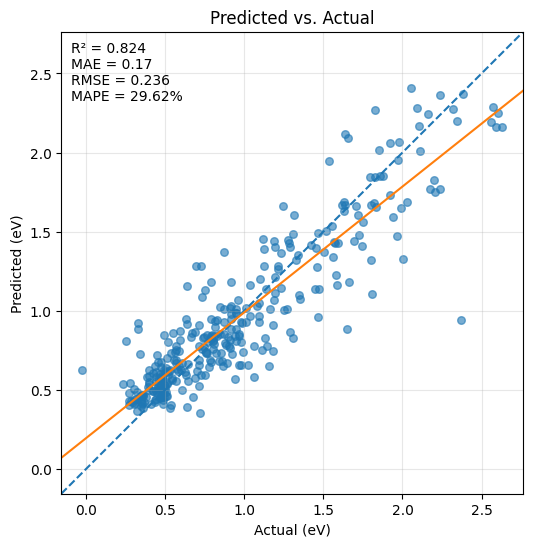

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics as skm

def plot_predicted_vs_actual(
    Y_test,
    Y_pred_test,
    *,
    title="Predicted vs. Actual",
    units="",
    fit_line=True,
    show_metrics=True,
    point_size=30,
    alpha=0.6,
    ax=None
):
    """
    Make a predicted vs. actual plot for regression.

    Parameters
    ----------
    y_true : array-like
        Ground-truth targets.
    y_pred : array-like
        Model predictions (aligned with y_true).
    title : str
        Plot title.
    units : str
        Optional suffix for axis labels, e.g. " (eV)" or " (MPa)".
    fit_line : bool
        If True, draw least-squares best-fit line (y_pred = a*y_true + b).
    show_metrics : bool
        If True, display R^2, MAE, RMSE, (and MAPE when possible).
    point_size : int
        Marker size for scatter points.
    alpha : float
        Marker transparency for scatter points.
    ax : matplotlib.axes.Axes or None
        Existing axes to draw on. Creates a new one if None.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The matplotlib axes with the plot.
    metrics_dict : dict
        Dictionary with computed metrics.
    """
    Y_test = np.asarray(Y_test).ravel()
    Y_pred_test = np.asarray(Y_pred_test).ravel()

    if Y_test.shape != Y_pred_test.shape:
        raise ValueError(f"Shape mismatch: y_test{Y_test.shape} vs y_pred{Y_pred_test.shape}")

    # Drop non-finite pairs
    mask = np.isfinite(Y_test) & np.isfinite(Y_pred_test)
    dropped = (~mask).sum()
    if dropped:
        Y_test, Y_pred_test = Y_test[mask], Y_pred_test[mask]

    # Metrics
    r2 = skm.r2_score(Y_test, Y_pred_test)
    mae = skm.mean_absolute_error(Y_test, Y_pred_test)
    rmse = np.sqrt(skm.mean_squared_error(Y_test, Y_pred_test))
    mape = None
    if not np.any(Y_test == 0):  # avoid division by zero
        mape = skm.mean_absolute_percentage_error(Y_test, Y_pred_test) * 100.0

    metrics_dict = {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE%": mape}

    # Axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # Limits padded a bit around the min/max of both arrays
    vmin = np.min([Y_test.min(), Y_pred_test.min()])
    vmax = np.max([Y_test.max(), Y_pred_test.max()])
    if vmin == vmax:
        vmin -= 1.0
        vmax += 1.0
    pad = 0.05 * (vmax - vmin)
    lims = (vmin - pad, vmax + pad)

    # Scatter
    ax.scatter(Y_test, Y_pred_test, s=point_size, alpha=alpha)

    # Identity line y = x
    ax.plot(lims, lims, linestyle="--")

    # Optional best-fit line (y_pred = a*y_true + b)
    if fit_line:
        a, b = np.polyfit(Y_test, Y_pred_test, 1)
        ax.plot(lims, a * np.array(lims) + b, linestyle="-")

    # Labels and layout
    ax.set_xlabel(f"Actual{units}")
    ax.set_ylabel(f"Predicted{units}")
    ax.set_title(title)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.3)

    # Metrics box
    if show_metrics:
        lines = [f"R² = {r2:.3f}", f"MAE = {mae:.3g}", f"RMSE = {rmse:.3g}"]
        if mape is not None:
            lines.append(f"MAPE = {mape:.2f}%")
        if dropped:
            lines.append(f"(dropped {dropped} non-finite pts)")
        ax.text(
            0.02, 0.98,
            "\n".join(lines),
            transform=ax.transAxes,
            va="top", ha="left"
        )

    return ax, metrics_dict


#from sklearn.datasets import make_regression
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_predict

# Fake data
#X, y = make_regression(n_samples=800, n_features=15, noise=15.0, random_state=0)

# Model and CV predictions (to avoid optimistic bias)
#model = RandomForestRegressor(random_state=0)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
Y_hat = cross_val_predict(gb_boruta, X, Y, cv=cv, n_jobs=-1)

# Plot
ax, metrics_dict = plot_predicted_vs_actual(Y, Y_hat, units=" (eV)")
print(metrics_dict)
plt.show()